In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('2019.pkl.gz')

In [3]:
df.event_type_de.unique()
# 11 is an ejection
#df[df.event_type_de == 11]

array(['period-start', 'jump-ball', 'missed_shot', 'rebound', 'turnover',
       'shot', 'foul', 'team-timeout', 'substitution', 'free-throw',
       'period-end', 'goal-tending', 'instant-replay', 11], dtype=object)

In [4]:
possessions_og = []
minutes_og = []

p_counter = 1
s_counter = 0
hs_counter = 0
as_counter = 0
gameid = 'NONE'

for row in df.itertuples():
    if row[1] != gameid:
        p_counter = 1
        s_counter = 0
        hs_counter = 0
        as_counter = 0
        h_p_prev = sorted([row[i] for i in range(62,71,2)])
        a_p_prev = sorted([row[i] for i in range(70,82,2)])
        gameid = row[1]

    h_players = sorted([row[i] for i in range(62,71,2)])
    a_players = sorted([row[i] for i in range(70,82,2)])

    h_score = row[37]
    a_score = row[38]
    #print(h_score,a_score)
    desc = row[39]
    h_team = row[40]
    a_team = row[41]

    seconds_elapsed = row[52]

    shot_made = row[49]
    is_d_rebound = row[56]
    is_turnover = row[59]
    player_swap =  h_players != h_p_prev or a_players != a_p_prev
    #print(row)

    if (shot_made == 1) or is_d_rebound or is_turnover or player_swap:
        poss_is_home = False
        if is_d_rebound:
            if h_team in desc:
                poss_is_home = False
            else:
                poss_is_home = True
        elif is_turnover:
            if h_team in desc:
                poss_is_home = True
            else:
                poss_is_home = False
        elif (shot_made == 1):
            if h_team in desc:
                poss_is_home = True
            else:
                poss_is_home = False  
        
        if not player_swap:
            possessions_og.append((h_p_prev,a_p_prev,poss_is_home,p_counter,h_score-hs_counter,a_score-as_counter))
            minutes_og.append((h_p_prev,a_p_prev,poss_is_home,seconds_elapsed-s_counter,h_score-hs_counter,a_score-as_counter))
            #assert(h_score-hs_counter==0 or a_score-as_counter ==0)
        p_counter = 1
        s_counter = seconds_elapsed
        as_counter = a_score
        hs_counter = h_score
 
    h_p_prev = h_players
    a_p_prev = a_players


In [5]:
number_of_min_examples = 0
minutes = [_ for _ in minutes_og if _[-3] >= 0]
possessions = [_ for _ in possessions_og if _[-3] >= 1]
len(minutes),len(possessions)

(253367, 253367)

In [6]:
TARGET = possessions

In [7]:
players = set()
for mins in TARGET:
    players = players.union(set(mins[0])).union(set(mins[1]))
players_list = sorted(list(players))
players_idx = {k:i for i,k in enumerate(players_list)}
n_players = len(players_list)
players_idx['LeBron James']

330

In [8]:
X_dict = {}
ROWS = len(TARGET)
y_target = np.zeros(ROWS)
HFA_BIAS = 1e-2

for i,mins in enumerate(TARGET):
    amount = mins[-3]
    h_value = mins[-2]
    a_value = mins[-1]
    
    
    #print(mins)
    if mins[-4]:         # home team on offense
        for hp in mins[0]:
            X_dict[(i,players_idx[hp])] = 1
        for ap in mins[1]:
            X_dict[(i,n_players+players_idx[ap])] = -1

        X_dict[(i,n_players*2)] = HFA_BIAS
        y_target[i] = h_value-a_value
    else:
        for hp in mins[0]:
            X_dict[(i,n_players+players_idx[hp])] = 1
        for ap in mins[1]:
            X_dict[(i,players_idx[ap])] = -1

        X_dict[(i,n_players*2+1)] = HFA_BIAS
        y_target[i] = h_value-a_value




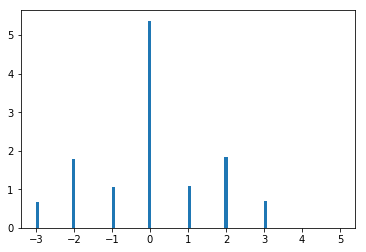

In [9]:
_ = plt.hist(y_target,100,density=True)

In [10]:
import scipy.sparse
X = scipy.sparse.dok_matrix((ROWS,n_players*2+2))
X._update(X_dict)
X = scipy.sparse.csr_matrix(X)

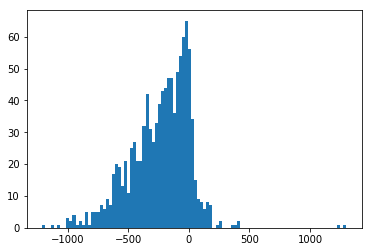

In [11]:
_ = plt.hist(np.array(X.sum(0))[0],100)

In [12]:
from sklearn import linear_model

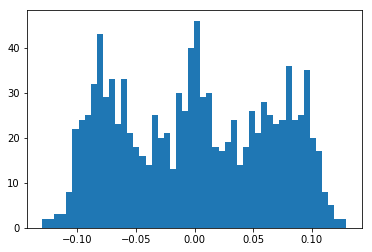

In [13]:
clf = linear_model.Ridge(alpha=10000,fit_intercept=False)
clf.fit(X,y_target)
_ = plt.hist(clf.coef_,50)


In [14]:
print(100*clf.coef_[-1],100*clf.coef_[-2])
t_score = 100*(clf.coef_[:clf.coef_.shape[0]//2-1] + clf.coef_[clf.coef_.shape[0]//2-1:-2])
v = np.argsort(t_score)[::-1]
for i in v:
    #try:
    name = players_list[i]
    #if name in ['LeBron James','Rudy Gobert','Stephen Curry','Kevin Knox','Tyson Chandler','James Harden']:
    print('{:30s} {:.2f} {:.2f}\t{:.2f}'.format(name,100*clf.coef_[i],100*clf.coef_[i+n_players],t_score[i]))

-2.7782997571535923 2.5499365908775853
Stephen Curry                  11.10 -8.20	2.90
Danny Green                    10.62 -7.76	2.87
Kevin Durant                   12.44 -9.93	2.51
Paul George                    11.47 -9.08	2.38
Pascal Siakam                  10.54 -8.43	2.10
Giannis Antetokounmpo          10.60 -8.69	1.91
Joe Ingles                     11.10 -9.28	1.83
Jusuf Nurkic                   8.07 -6.30	1.77
Eric Bledsoe                   10.32 -8.54	1.77
Khris Middleton                10.37 -8.62	1.74
Brook Lopez                    9.70 -8.04	1.66
Kevon Looney                   7.77 -6.14	1.62
Nikola Vucevic                 9.48 -7.86	1.62
Kyle Lowry                     10.34 -8.72	1.62
Damian Lillard                 11.76 -10.15	1.61
Raul Neto                      4.63 -3.03	1.60
Fred VanVleet                  9.17 -7.57	1.59
Paul Millsap                   8.75 -7.16	1.58
Draymond Green                 9.49 -7.91	1.58
Eric Gordon                    10.05 -8.57	1.48
Kyrie Ir